<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S6/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from itertools import chain
from inspect import signature
from functools import lru_cache as cache
from collections import defaultdict, namedtuple
#from torch.utils import 

**Target**: create an architecture with less than 10k parameters so accordingly chooses the imput and output channels.Here I have choosen the channels between 10 and 20.

**Analysis**: Adding dropout after max pooling has yielded better results in terms
of Accuracy rather than after each layer

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        #self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.pool1 = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        #self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        #self.pool2 = nn.MaxPool2d(2, 2)
        #self.conv5 = nn.Conv2d(256, 512, 3)
        #self.conv6 = nn.Conv2d(512, 1024, 3)
        #self.conv7 = nn.Conv2d(1024, 10, 3)
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=10),
                                   GhostBatchNorm(10,2)
                                   #nn.Dropout(0.1)
                                   )

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=16),
                                   GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
        )
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=20),
                                   GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   )                          
        
        self.pool1 =  nn.MaxPool2d(2,2)
         
        
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=10),
                                   GhostBatchNorm(10,2),
                                   nn.Dropout(0.1)
                                   ) 
        
        #self.pool2 =  nn.MaxPool2d(2,2)

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=20),
                                   GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   ) 
        
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=16),
                                   GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
                                   ) 
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding=0)
                                   #nn.ReLU()
                                   #nn.BatchNorm2d(num_features=10)
                                   #nn.DroupOut2d()
                                   )
        self.gap  =  nn.Sequential(nn.AvgPool2d(kernel_size=7)) 

        
        
        
        self.dropout = nn.Dropout(0.1)

              
        



    def forward(self, x):
        #x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        #x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        #x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        #x = x.view(-1, 10)
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.conv4(x)
        #x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.conv7(x)
        x = self.gap(x)
        

        x = x.view(-1, 10)
        



        return F.log_softmax(x)

Summary of our model architecture.

1. Used Batch Normalization at every layer and dropout after max pooling layer

2. Used GAP of 7*7 at the end

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        #self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        #self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.pool1 = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        #self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        #self.pool2 = nn.MaxPool2d(2, 2)
        #self.conv5 = nn.Conv2d(256, 512, 3)
        #self.conv6 = nn.Conv2d(512, 1024, 3)
        #self.conv7 = nn.Conv2d(1024, 10, 3)
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=10),
                                   #GhostBatchNorm(10,2)
                                   #nn.Dropout(0.1)
                                   )

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=16),
                                   #GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
        )
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=20),
                                   #GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   )                          
        
        self.pool1 =  nn.MaxPool2d(2,2)
         
        
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=10),
                                   #GhostBatchNorm(10,2),
                                   nn.Dropout(0.1)
                                   ) 
        
        #self.pool2 =  nn.MaxPool2d(2,2)

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=20),
                                   #GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   ) 
        
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=16),
                                   #GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
                                   ) 
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding=0)
                                   #nn.ReLU()
                                   #nn.BatchNorm2d(num_features=10)
                                   #nn.DroupOut2d()
                                   )
        self.gap  =  nn.Sequential(nn.AvgPool2d(kernel_size=7)) 

        
        
        
        self.dropout = nn.Dropout(0.1)

              
        



    def forward(self, x):
        #x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        #x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        #x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        #x = x.view(-1, 10)
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.conv4(x)
        #x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.conv7(x)
        x = self.gap(x)
        

        x = x.view(-1, 10)
        



        return F.log_softmax(x)



In [0]:
def summary_of_model1():
    !pip install torchsummary
    from torchsummary import summary
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net().to(device)
    summary(model, input_size=(1, 28, 28))
    return model

def summary_of_model2():
    !pip install torchsummary
    from torchsummary import summary
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net2().to(device)
    summary(model, input_size=(1, 28, 28))
    return model


Apply RamdomRotation to image by 7 degree for getting better accuracy tried 

with other degrees like 5,6 and 10 this was best . 

 converting the image to tensor and normalizing the pixel of image.Used Random Affine image augmentation techniques.

We are doing image Augmentation on the train dataset not on testing dataset.
Used ColorJitter with different combination of parameters as well as resize function of transform but didnot gave better results in terms of accuracy so commented it.

In [0]:


def loading_of_dataset1():
    torch.manual_seed(1)
    batch_size = 256

    kwargs = {'num_workers': 1, 'pin_memory': True} #if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.Resize((30,30)),                          
                        transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        #transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),                          
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
    return train_loader,test_loader  
  
def loading_of_dataset2():
    torch.manual_seed(1)
    batch_size = 128

    kwargs = {'num_workers': 1, 'pin_memory': True} #if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
       datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            #transforms.Resize((30,30)),                          
                            transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                            transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                            #transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),                          
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),

        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=batch_size, shuffle=True, **kwargs)   
    return train_loader,test_loader

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from tqdm import tqdm
train_losses=[]
#test_losses=[]
train_acc=[]
test_acc=[]
t_loss=[]
total_loss=[]
total_acc=[]
def train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=None):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        #l1_critic=nn.L1Loss(size_average=False)
        #reg_loss= 0
        #for param in model.parameters():
        
         #   reg_loss = reg_loss + l1_critic(param)
        #factor=0.0005  
        #loss=loss + (factor*reg_loss)
        if L1lambda:
           with torch.enable_grad():
             l1_loss=0
             for param in model.parameters():
               l1_loss+=torch.sum(param.abs())
             loss+=L1lambda*l1_loss  
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred=y_pred.argmax(dim=1,keepdim=True)
        correct+=pred.eq(target.view_as(pred)).sum().item()
        processed+=len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print("predicted",pred)
            #print("target",target)
            #print()
            correct += pred.eq(target.view_as(pred)).sum().item()
            #figure = plt.figure()
            #no_of_images=25
            #count=0
            #for index in range(1,no_of_images+1):
             #    for a in np.arange(25):
             #        if(pred[a]!=target[a]):
             #           plt.subplot(5,5,index)
             #
             #          plt.axis('off')
             #          plt.imshow(data[index].cpu().numpy().squeeze(),cmap='gray_r')
             #           count=count+1

              #          if(count==25):
              #            break
            #   
            #       plt.imshow(data[index].numpy(),cmap='gray_r')


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    t_loss.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))




Using epoch of 15.Using StepLR function from lr schedular module using step_size of 5 is giving better accuracy compared to 4 and 6.This is basically done by Hit and Trial.

Findong 25 misclassified images using Ghost Batch Normalization in the model

In [0]:
def misclassified_images():
    train_loader,test_loader=loading_of_dataset1()
    dataiter = iter(test_loader)
    #data,target = dataiter.next()
    #data, target = data.to(device), target.to(device)
    #output = model(data)
    #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
    #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    #print(pred)
    #print()
    #correct += pred.eq(target.view_as(pred)).sum().item()
    figure = plt.figure()
    plt.title('Misclassified images when using GBN')
    #no_of_images=25
    count=0
    print("with GBN misclassified image")
    while(count<25):
          data,target = dataiter.next()
          device = 'cuda' if torch.cuda.is_available() else 'cpu'
          model=summary_of_model1()
          model_save_name = 'S6_Assignment_Misclasssified_GBN.pt'
          path = F"/content/gdrive/My Drive/{model_save_name}"
          model.load_state_dict(torch.load(path))  #loading the model
          model.eval()
          data, target = data.to(device), target.to(device)
          output = model(data)
          #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          
          for a in range(256):
              if(pred[a]!=target[a]):
                 #print("pred",pred[a])
                 #print("targ",target[a])
                 plt.subplot(5,5,count+1)
                 plt.axis('off')
                 
                 plt.imshow(data[a].cpu().numpy().squeeze(),cmap='gray_r')
                 count=count+1

              if(count==25):
                  break


Findong 25 misclassified images using Batch Normalization in the model

In [0]:
def misclassified_images_BN():
    train_loader,test_loader=loading_of_dataset2()
    dataiter = iter(test_loader)
    #data,target = dataiter.next()
    #data, target = data.to(device), target.to(device)
    #output = model(data)
    #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
    #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    #print(pred)
    #print()
    #correct += pred.eq(target.view_as(pred)).sum().item()
    figure = plt.figure()
    plt.title('Misclassified images when using BN')
    #no_of_images=25
    count=0
    print("with BN misclassified image")
   
    while(count<25):
          data,target = dataiter.next()
          device = 'cuda' if torch.cuda.is_available() else 'cpu'
          model=summary_of_model2()
          model_save_name = 'S6_Assignment_Misclasssified_BN.pt' 
          path = F"/content/gdrive/My Drive/{model_save_name}"
          model.load_state_dict(torch.load(path))  # loading the model
          model.eval()
          data, target = data.to(device), target.to(device)
          output = model(data)
          #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)
            # get the index of the max log-probability

          
          for a in range(128):
              if(pred[a]!=target[a]):
                 #print("pred",pred[a])
                 #print("targ",target[a])
                 plt.subplot(5,5,count+1)
                 plt.axis('off')
                 
                 plt.imshow(data[a].cpu().numpy().squeeze(),cmap='gray_r')
                 count=count+1

              if(count==25):
                  break



**Target:**
1. Getting an accuracy of 99.4 with less than 10k parametrs under 15 epochs.
Results:
1. Parameters: 9736 
2. Best Train Accuracy:98.09
3. Best Test Accuracy: 99.45

**Analysis:**

1. The model is doing pretty well not overfitting as well as getting consistent accuracy.

2. Seeing image sample ,we get to know we can add slight rotation for better accuracy.
3. Doing image augmentation and choosing the step size of LR schedular wisely can improve the accuracy.

4. Adding too many image augmentation techniques work in a negative way reduces the accuracy or have not much impact

In [0]:
from torch.optim.lr_scheduler import StepLR

def l1_l2_with_GBN():
    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model = Net().to(device)
    model=summary_of_model1()
    train_loader,test_loader=loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("....L1_L2_GBN...")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]   

def l1_with_GBN():

    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model=Net().to(device)
    model=summary_of_model1()
    train_loader,test_loader=loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L1_with_GBN..")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def l2_with_GBN():
    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model=Net().to(device)
    model=summary_of_model1()
    train_loader,test_loader=loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L2_with_GBN..")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]    

def without_l1_l2_GBN():
    global t_loss
    global test_acc
     
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #model=Net().to(device)
    model=summary_of_model1()
    train_loader,test_loader=loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...without_L1_L2_GBN..")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    
        
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def BN_without_L1_L2():
    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model=Net2().to(device)
    model=summary_of_model2()
    train_loader,test_loader=loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...without_L1_L2_BN..")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    #misclassified_images_BN() 
    #torch.save(model,"a.pt")
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def l1_with_BN():
    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model=Net2().to(device)
    model=summary_of_model2()
    train_loader,test_loader=loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L1_with_BN..")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def l1_l2_with_BN():
    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model = Net2().to(device)
    model=summary_of_model2()
    train_loader,test_loader=loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("....L1_L2_BN...")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]    
def l2_with_BN():
    global t_loss
    global test_acc
    device= 'cuda' if torch.cuda.is_available() else 'cpu'
    #model=Net2().to(device)
    model=summary_of_model2()
    train_loader,test_loader=loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L2_with_BN..")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]


    
#l1_critic=nn.L1Loss(size_average=False)
#reg_loss= 0
#for param in model.parameters():
 #   print(param)
 #   reg_loss = reg_loss + l1_critic(param)
#factor=0.0005  
#loss=loss + (factor*reg_loss)

#for epoch in range(1, 5):
 #   train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
  #  test(model, device, test_loader)

In [0]:
l1_l2_with_GBN()
l1_with_GBN()
l2_with_GBN()
without_l1_l2_GBN()
BN_without_L1_L2()
l1_with_BN()
l2_with_BN()
l1_l2_with_BN()





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/235 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.4441702961921692 batch_id=234 Accuracy=63.30: 100%|██████████| 235/235 [00:21<00:00, 11.16it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2866, Accuracy: 9497/10000 (94.97%)



loss=0.2559341788291931 batch_id=234 Accuracy=92.33: 100%|██████████| 235/235 [00:21<00:00, 11.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 9732/10000 (97.32%)



loss=0.16789299249649048 batch_id=234 Accuracy=94.90: 100%|██████████| 235/235 [00:20<00:00, 11.20it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9817/10000 (98.17%)



loss=0.17097720503807068 batch_id=234 Accuracy=95.81: 100%|██████████| 235/235 [00:21<00:00, 11.00it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9843/10000 (98.43%)



loss=0.12832237780094147 batch_id=234 Accuracy=96.46: 100%|██████████| 235/235 [00:20<00:00, 11.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9871/10000 (98.71%)



loss=0.1010247990489006 batch_id=234 Accuracy=96.72: 100%|██████████| 235/235 [00:21<00:00, 11.14it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9877/10000 (98.77%)



loss=0.08179076761007309 batch_id=234 Accuracy=96.94: 100%|██████████| 235/235 [00:21<00:00, 11.09it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9886/10000 (98.86%)



loss=0.11132227629423141 batch_id=234 Accuracy=97.08: 100%|██████████| 235/235 [00:21<00:00, 11.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9904/10000 (99.04%)



loss=0.07644447684288025 batch_id=234 Accuracy=97.32: 100%|██████████| 235/235 [00:20<00:00, 11.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9898/10000 (98.98%)



loss=0.16286581754684448 batch_id=234 Accuracy=97.35: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9913/10000 (99.13%)



loss=0.07229629904031754 batch_id=234 Accuracy=97.55: 100%|██████████| 235/235 [00:21<00:00, 11.02it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9900/10000 (99.00%)



loss=0.10717732459306717 batch_id=234 Accuracy=97.61: 100%|██████████| 235/235 [00:20<00:00, 11.22it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)



loss=0.06183671951293945 batch_id=234 Accuracy=97.58: 100%|██████████| 235/235 [00:21<00:00, 10.99it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)



loss=0.09443007409572601 batch_id=234 Accuracy=97.78: 100%|██████████| 235/235 [00:21<00:00, 11.11it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9903/10000 (99.03%)



loss=0.06973723322153091 batch_id=234 Accuracy=97.84: 100%|██████████| 235/235 [00:21<00:00, 11.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)



loss=0.04631683975458145 batch_id=234 Accuracy=97.86: 100%|██████████| 235/235 [00:21<00:00, 11.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)



loss=0.1398596316576004 batch_id=234 Accuracy=97.89: 100%|██████████| 235/235 [00:21<00:00, 11.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)



loss=0.07972083985805511 batch_id=234 Accuracy=98.00: 100%|██████████| 235/235 [00:21<00:00, 11.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)



loss=0.09285181015729904 batch_id=234 Accuracy=98.02: 100%|██████████| 235/235 [00:21<00:00, 11.16it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9918/10000 (99.18%)



loss=0.04374822974205017 batch_id=234 Accuracy=97.97: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.19%)



loss=0.0556538924574852 batch_id=234 Accuracy=98.12: 100%|██████████| 235/235 [00:21<00:00, 11.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)



loss=0.061025649309158325 batch_id=234 Accuracy=98.11: 100%|██████████| 235/235 [00:21<00:00, 11.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)



loss=0.08884978294372559 batch_id=234 Accuracy=98.16: 100%|██████████| 235/235 [00:20<00:00, 11.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)



loss=0.07663780450820923 batch_id=234 Accuracy=98.16: 100%|██████████| 235/235 [00:21<00:00, 11.11it/s]



Test set: Average loss: 0.0241, Accuracy: 9916/10000 (99.16%)



  0%|          | 0/235 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.4445681869983673 batch_id=234 Accuracy=65.16: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2781, Accuracy: 9427/10000 (94.27%)



loss=0.2899813652038574 batch_id=234 Accuracy=92.72: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1283, Accuracy: 9679/10000 (96.79%)



loss=0.2236204296350479 batch_id=234 Accuracy=94.90: 100%|██████████| 235/235 [00:21<00:00, 11.14it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9815/10000 (98.15%)



loss=0.21520067751407623 batch_id=234 Accuracy=95.83: 100%|██████████| 235/235 [00:21<00:00, 11.11it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9832/10000 (98.32%)



loss=0.09435456246137619 batch_id=234 Accuracy=96.50: 100%|██████████| 235/235 [00:20<00:00, 11.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9854/10000 (98.54%)



loss=0.08653382211923599 batch_id=234 Accuracy=96.74: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9880/10000 (98.80%)



loss=0.06937625259160995 batch_id=234 Accuracy=96.92: 100%|██████████| 235/235 [00:21<00:00, 11.16it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9886/10000 (98.86%)



loss=0.1334158033132553 batch_id=234 Accuracy=97.17: 100%|██████████| 235/235 [00:21<00:00, 11.07it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9879/10000 (98.79%)



loss=0.1081891655921936 batch_id=234 Accuracy=97.32: 100%|██████████| 235/235 [00:21<00:00, 11.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9884/10000 (98.84%)



loss=0.18172253668308258 batch_id=234 Accuracy=97.48: 100%|██████████| 235/235 [00:21<00:00, 11.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9889/10000 (98.89%)



loss=0.06754405051469803 batch_id=234 Accuracy=97.59: 100%|██████████| 235/235 [00:21<00:00, 11.04it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9886/10000 (98.86%)



loss=0.11327221989631653 batch_id=234 Accuracy=97.57: 100%|██████████| 235/235 [00:21<00:00, 11.16it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9910/10000 (99.10%)



loss=0.046242356300354004 batch_id=234 Accuracy=97.68: 100%|██████████| 235/235 [00:20<00:00, 11.22it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9925/10000 (99.25%)



loss=0.11236312240362167 batch_id=234 Accuracy=97.72: 100%|██████████| 235/235 [00:21<00:00, 11.15it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)



loss=0.09256329387426376 batch_id=234 Accuracy=97.87: 100%|██████████| 235/235 [00:21<00:00, 11.05it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9918/10000 (99.18%)



loss=0.03479928895831108 batch_id=234 Accuracy=97.94: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]



Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)



loss=0.16035699844360352 batch_id=234 Accuracy=97.83: 100%|██████████| 235/235 [00:21<00:00, 11.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9920/10000 (99.20%)



loss=0.06942440569400787 batch_id=234 Accuracy=98.08: 100%|██████████| 235/235 [00:21<00:00, 11.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99.16%)



loss=0.0671703964471817 batch_id=234 Accuracy=98.02: 100%|██████████| 235/235 [00:20<00:00, 11.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9908/10000 (99.08%)



loss=0.0609840452671051 batch_id=234 Accuracy=98.03: 100%|██████████| 235/235 [00:21<00:00, 11.18it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)



loss=0.08305767178535461 batch_id=234 Accuracy=98.11: 100%|██████████| 235/235 [00:21<00:00, 11.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)



loss=0.06260472536087036 batch_id=234 Accuracy=98.15: 100%|██████████| 235/235 [00:21<00:00, 10.99it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9906/10000 (99.06%)



loss=0.07730823755264282 batch_id=234 Accuracy=98.14: 100%|██████████| 235/235 [00:20<00:00, 11.23it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9921/10000 (99.21%)



loss=0.09007225185632706 batch_id=234 Accuracy=98.19: 100%|██████████| 235/235 [00:20<00:00, 11.30it/s]



Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/235 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.43824681639671326 batch_id=234 Accuracy=65.08: 100%|██████████| 235/235 [00:20<00:00, 11.52it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2725, Accuracy: 9461/10000 (94.61%)



loss=0.27802374958992004 batch_id=234 Accuracy=92.73: 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1239, Accuracy: 9683/10000 (96.83%)



loss=0.22432343661785126 batch_id=234 Accuracy=94.91: 100%|██████████| 235/235 [00:20<00:00, 11.55it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9817/10000 (98.17%)



loss=0.22669412195682526 batch_id=234 Accuracy=95.83: 100%|██████████| 235/235 [00:19<00:00, 11.81it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9841/10000 (98.41%)



loss=0.09261006861925125 batch_id=234 Accuracy=96.44: 100%|██████████| 235/235 [00:20<00:00, 11.53it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9848/10000 (98.48%)



loss=0.07329242676496506 batch_id=234 Accuracy=96.66: 100%|██████████| 235/235 [00:20<00:00, 11.61it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9875/10000 (98.75%)



loss=0.058290377259254456 batch_id=234 Accuracy=96.92: 100%|██████████| 235/235 [00:20<00:00, 11.65it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9883/10000 (98.83%)



loss=0.11218943446874619 batch_id=234 Accuracy=97.13: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9892/10000 (98.92%)



loss=0.11518696695566177 batch_id=234 Accuracy=97.23: 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9879/10000 (98.79%)



loss=0.17335574328899384 batch_id=234 Accuracy=97.40: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9901/10000 (99.01%)



loss=0.0512215681374073 batch_id=234 Accuracy=97.48: 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9882/10000 (98.82%)



loss=0.12207566946744919 batch_id=234 Accuracy=97.61: 100%|██████████| 235/235 [00:20<00:00, 11.49it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9906/10000 (99.06%)



loss=0.03740213066339493 batch_id=234 Accuracy=97.65: 100%|██████████| 235/235 [00:20<00:00, 11.49it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9909/10000 (99.09%)



loss=0.10637090355157852 batch_id=234 Accuracy=97.76: 100%|██████████| 235/235 [00:20<00:00, 11.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)



loss=0.09844023734331131 batch_id=234 Accuracy=97.90: 100%|██████████| 235/235 [00:21<00:00, 10.99it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)



loss=0.027541102841496468 batch_id=234 Accuracy=97.85: 100%|██████████| 235/235 [00:21<00:00, 11.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9905/10000 (99.05%)



loss=0.16134148836135864 batch_id=234 Accuracy=97.83: 100%|██████████| 235/235 [00:20<00:00, 11.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)



loss=0.04878707230091095 batch_id=234 Accuracy=97.98: 100%|██████████| 235/235 [00:20<00:00, 11.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)



loss=0.06879734247922897 batch_id=234 Accuracy=98.03: 100%|██████████| 235/235 [00:20<00:00, 11.29it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9898/10000 (98.98%)



loss=0.06476537138223648 batch_id=234 Accuracy=97.98: 100%|██████████| 235/235 [00:21<00:00, 11.06it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)



loss=0.08821777254343033 batch_id=234 Accuracy=98.04: 100%|██████████| 235/235 [00:20<00:00, 11.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)



loss=0.06142197176814079 batch_id=234 Accuracy=98.15: 100%|██████████| 235/235 [00:20<00:00, 11.25it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9905/10000 (99.05%)



loss=0.08278016000986099 batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [00:20<00:00, 11.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)



loss=0.09547046571969986 batch_id=234 Accuracy=98.16: 100%|██████████| 235/235 [00:20<00:00, 11.44it/s]



Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/235 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.43906649947166443 batch_id=234 Accuracy=65.16: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2765, Accuracy: 9442/10000 (94.42%)



loss=0.2749742567539215 batch_id=234 Accuracy=92.67: 100%|██████████| 235/235 [00:20<00:00, 11.69it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1237, Accuracy: 9687/10000 (96.87%)



loss=0.21571843326091766 batch_id=234 Accuracy=94.93: 100%|██████████| 235/235 [00:19<00:00, 11.83it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9803/10000 (98.03%)



loss=0.24240435659885406 batch_id=234 Accuracy=95.84: 100%|██████████| 235/235 [00:19<00:00, 11.82it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9810/10000 (98.10%)



loss=0.09401511400938034 batch_id=234 Accuracy=96.45: 100%|██████████| 235/235 [00:19<00:00, 11.86it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9840/10000 (98.40%)



loss=0.08411741256713867 batch_id=234 Accuracy=96.68: 100%|██████████| 235/235 [00:19<00:00, 11.75it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9854/10000 (98.54%)



loss=0.05387285351753235 batch_id=234 Accuracy=96.93: 100%|██████████| 235/235 [00:19<00:00, 11.80it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9888/10000 (98.88%)



loss=0.11695945262908936 batch_id=234 Accuracy=97.14: 100%|██████████| 235/235 [00:20<00:00, 11.73it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9877/10000 (98.77%)



loss=0.10956084728240967 batch_id=234 Accuracy=97.22: 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9878/10000 (98.78%)



loss=0.1608528047800064 batch_id=234 Accuracy=97.40: 100%|██████████| 235/235 [00:20<00:00, 11.58it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)



loss=0.0494467057287693 batch_id=234 Accuracy=97.53: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9885/10000 (98.85%)



loss=0.10347362607717514 batch_id=234 Accuracy=97.59: 100%|██████████| 235/235 [00:20<00:00, 11.67it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9898/10000 (98.98%)



loss=0.03609444946050644 batch_id=234 Accuracy=97.58: 100%|██████████| 235/235 [00:19<00:00, 11.84it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9918/10000 (99.18%)



loss=0.11803317815065384 batch_id=234 Accuracy=97.76: 100%|██████████| 235/235 [00:19<00:00, 11.77it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)



loss=0.10056626051664352 batch_id=234 Accuracy=97.92: 100%|██████████| 235/235 [00:19<00:00, 11.95it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)



loss=0.026241302490234375 batch_id=234 Accuracy=97.83: 100%|██████████| 235/235 [00:19<00:00, 12.15it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)



loss=0.16031582653522491 batch_id=234 Accuracy=97.83: 100%|██████████| 235/235 [00:19<00:00, 12.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)



loss=0.059062521904706955 batch_id=234 Accuracy=98.02: 100%|██████████| 235/235 [00:19<00:00, 12.11it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9913/10000 (99.13%)



loss=0.05358072742819786 batch_id=234 Accuracy=98.03: 100%|██████████| 235/235 [00:19<00:00, 12.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)



loss=0.05522153899073601 batch_id=234 Accuracy=98.04: 100%|██████████| 235/235 [00:19<00:00, 11.91it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)



loss=0.07852035760879517 batch_id=234 Accuracy=98.09: 100%|██████████| 235/235 [00:20<00:00, 11.64it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)



loss=0.04162953421473503 batch_id=234 Accuracy=98.10: 100%|██████████| 235/235 [00:19<00:00, 11.76it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9916/10000 (99.16%)



loss=0.07143493741750717 batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [00:20<00:00, 11.70it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)



loss=0.0737735703587532 batch_id=234 Accuracy=98.23: 100%|██████████| 235/235 [00:20<00:00, 11.47it/s]



Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.16302160918712616 batch_id=468 Accuracy=78.26: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1222, Accuracy: 9662/10000 (96.62%)



loss=0.18495289981365204 batch_id=468 Accuracy=95.02: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9809/10000 (98.09%)



loss=0.13267846405506134 batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9864/10000 (98.64%)



loss=0.10638672113418579 batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9891/10000 (98.91%)



loss=0.06981467455625534 batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9893/10000 (98.93%)



loss=0.04676245525479317 batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)



loss=0.042976200580596924 batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9917/10000 (99.17%)



loss=0.08771032094955444 batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.15%)



loss=0.0938059464097023 batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)



loss=0.09368280321359634 batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9930/10000 (99.30%)



loss=0.055321868509054184 batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99.05%)



loss=0.052344679832458496 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9914/10000 (99.14%)



loss=0.028814157471060753 batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)



loss=0.07785680145025253 batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)



loss=0.04753771424293518 batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99.20%)



loss=0.01753692887723446 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99.20%)



loss=0.12928037345409393 batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)



loss=0.04813725873827934 batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)



loss=0.06621123850345612 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)



loss=0.03343324363231659 batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9924/10000 (99.24%)



loss=0.052775442600250244 batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)



loss=0.025986144319176674 batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)



loss=0.04284128174185753 batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)



loss=0.04165610671043396 batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]



Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.15621255338191986 batch_id=468 Accuracy=78.28: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1508, Accuracy: 9557/10000 (95.57%)



loss=0.19265778362751007 batch_id=468 Accuracy=95.06: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9817/10000 (98.17%)



loss=0.13124151527881622 batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9859/10000 (98.59%)



loss=0.09610054641962051 batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:23<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)



loss=0.09024965763092041 batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)



loss=0.05311637744307518 batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9880/10000 (98.80%)



loss=0.053268738090991974 batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)



loss=0.09469777345657349 batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)



loss=0.09723133593797684 batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)



loss=0.08969871699810028 batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9920/10000 (99.20%)



loss=0.0716557502746582 batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99.08%)



loss=0.04914524406194687 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9920/10000 (99.20%)



loss=0.04413262754678726 batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)



loss=0.07611232995986938 batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)



loss=0.05931569263339043 batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:23<00:00, 19.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)



loss=0.02357994019985199 batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)



loss=0.12914980947971344 batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)



loss=0.03768245875835419 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)



loss=0.06635458022356033 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)



loss=0.045471858233213425 batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:23<00:00, 20.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)



loss=0.07549839466810226 batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9919/10000 (99.19%)



loss=0.03823750838637352 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)



loss=0.05238131061196327 batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)



loss=0.04896922409534454 batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.16456028819084167 batch_id=468 Accuracy=78.22: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1385, Accuracy: 9600/10000 (96.00%)



loss=0.17436005175113678 batch_id=468 Accuracy=94.95: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9812/10000 (98.12%)



loss=0.11675912141799927 batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9870/10000 (98.70%)



loss=0.08954782038927078 batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9884/10000 (98.84%)



loss=0.08232947438955307 batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9892/10000 (98.92%)



loss=0.04805659130215645 batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9896/10000 (98.96%)



loss=0.04392601177096367 batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9915/10000 (99.15%)



loss=0.08304809778928757 batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9913/10000 (99.13%)



loss=0.07915476709604263 batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)



loss=0.09283164143562317 batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)



loss=0.05333665385842323 batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9896/10000 (98.96%)



loss=0.04488907381892204 batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)



loss=0.03343191742897034 batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)



loss=0.06590848416090012 batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)



loss=0.04782448336482048 batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)



loss=0.019272491335868835 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9910/10000 (99.10%)



loss=0.15017449855804443 batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)



loss=0.050983648747205734 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)



loss=0.08126199245452881 batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)



loss=0.037429407238960266 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)



loss=0.08099908381700516 batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)



loss=0.02855241857469082 batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)



loss=0.06021091341972351 batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)



loss=0.0465521477162838 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.15286126732826233 batch_id=468 Accuracy=78.24: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1433, Accuracy: 9590/10000 (95.90%)



loss=0.20463526248931885 batch_id=468 Accuracy=95.05: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9819/10000 (98.19%)



loss=0.1316075176000595 batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9855/10000 (98.55%)



loss=0.08410387486219406 batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9897/10000 (98.97%)



loss=0.10291458666324615 batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9904/10000 (99.04%)



loss=0.050491537898778915 batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9896/10000 (98.96%)



loss=0.060420647263526917 batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)



loss=0.08804500102996826 batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)



loss=0.10425014793872833 batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9914/10000 (99.14%)



loss=0.09885568916797638 batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)



loss=0.0682041272521019 batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99.08%)



loss=0.061298172920942307 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)



loss=0.04582083970308304 batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)



loss=0.07908947765827179 batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9909/10000 (99.09%)



loss=0.058983176946640015 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)



loss=0.022234484553337097 batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)



loss=0.13049264252185822 batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9919/10000 (99.19%)



loss=0.06307727098464966 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)



loss=0.09012521803379059 batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)



loss=0.02803833782672882 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)



loss=0.06738437712192535 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)



loss=0.05285951867699623 batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)



loss=0.08500832319259644 batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)



loss=0.06465115398168564 batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]



Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)



with GBN misclassified image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

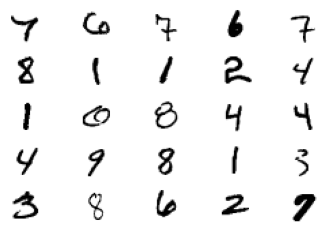

In [0]:
misclassified_images()

with BN misclassified image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

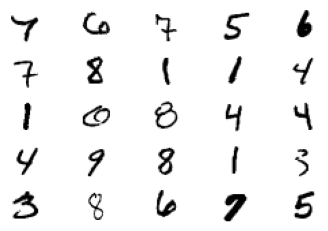

In [0]:
misclassified_images_BN()

saving the model which contains Ghost Batch Normalization

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls /content/gdrive/My Drive

model_save_name = 'S6_Assignment_Misclasssified_GBN.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model = summary_of_model1()
torch.save(model.state_dict(), path)
print("Saving Complete")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


saving the model which contains Batch Normalization

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'S6_Assignment_Misclasssified_BN.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model = summary_of_model2()
torch.save(model.state_dict(), path)
print("Saving Complete")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
total_loss

[[0.30341113319396973,
  0.09960855612754822,
  0.07638645572662353,
  0.060093116092681885,
  0.04903126854896545,
  0.05475700645446777,
  0.043077739477157595,
  0.03756534895896912,
  0.03834226710796356,
  0.033648569107055666,
  0.03558863270282745,
  0.03332516150474548,
  0.02754727110862732,
  0.02852613034248352,
  0.02997279009819031,
  0.027509448075294495,
  0.02701748631000519,
  0.02866202404499054,
  0.0268997526884079,
  0.025098342156410217,
  0.025827506160736084,
  0.022522523522377016,
  0.024531889390945433,
  0.02393666467666626],
 [0.26661501693725587,
  0.1178559425830841,
  0.07571973190307617,
  0.06114696383476257,
  0.051901952648162844,
  0.045434791278839114,
  0.041456785488128665,
  0.04285066590309143,
  0.04453027410507202,
  0.03784083852767944,
  0.03687743213176727,
  0.03395103619098663,
  0.031182066369056703,
  0.02730773890018463,
  0.030255985403060914,
  0.028180655813217163,
  0.026719192957878113,
  0.027681133794784547,
  0.027425341868400

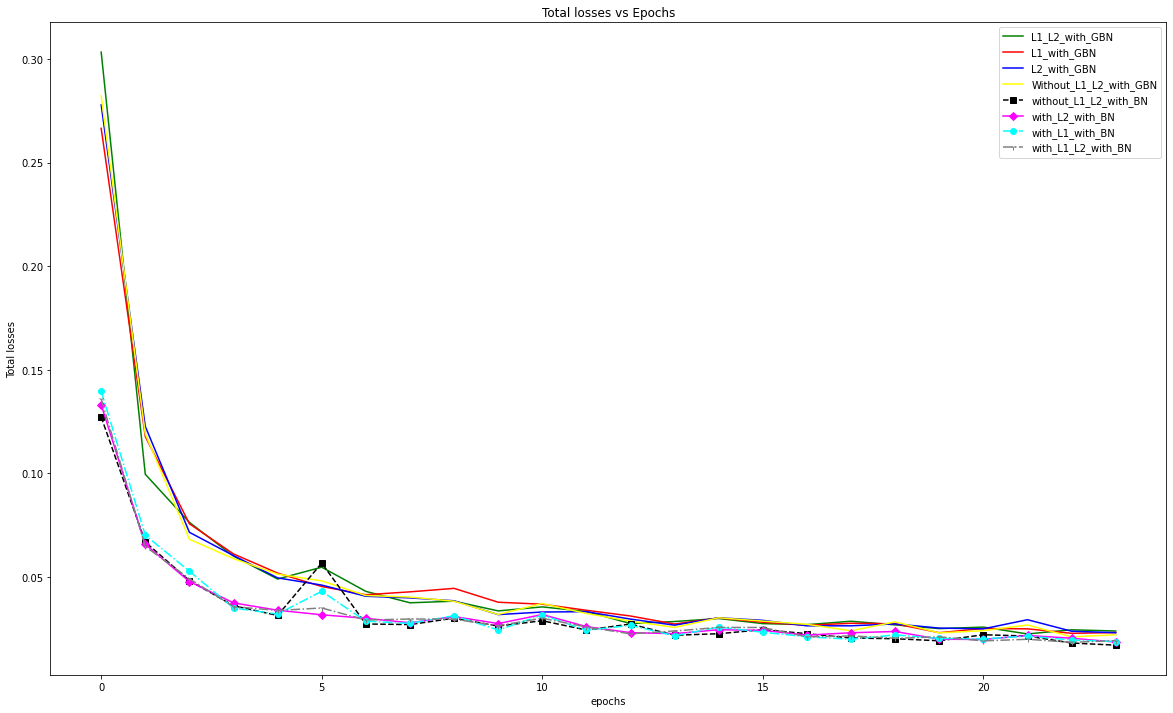

In [0]:
plt.figure(figsize=(20,12))
plt.plot(total_loss[0],color='Green',label='L1_L2_with_GBN')
plt.plot(total_loss[1],color='Red',label='L1_with_GBN')
plt.plot(total_loss[2],color='Blue',label='L2_with_GBN')
plt.plot(total_loss[3],color='Yellow',label='Without_L1_L2_with_GBN')
plt.plot(total_loss[4],c='Black',marker = 's' , ls = '--' , label = 'without_L1_L2_with_BN' )
plt.plot(total_loss[6],c='Magenta', marker = 'D' , ls = '-' , label = 'with_L2_with_BN' )
plt.plot(total_loss[5],c='Cyan' , marker = 'o' , ls = '-.' , label = 'with_L1_with_BN')
plt.plot(total_loss[7],c='Grey' , marker = '1' , ls = '-.' , label = 'with_L1_L2_with_BN')
plt.xlabel('Total Epoch ')
plt.ylabel(' Loss ')
plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))

plt.title('Total losses vs Epochs')
plt.legend()
plt.ylabel('Total losses')
plt.xlabel('epochs')
plt.show()

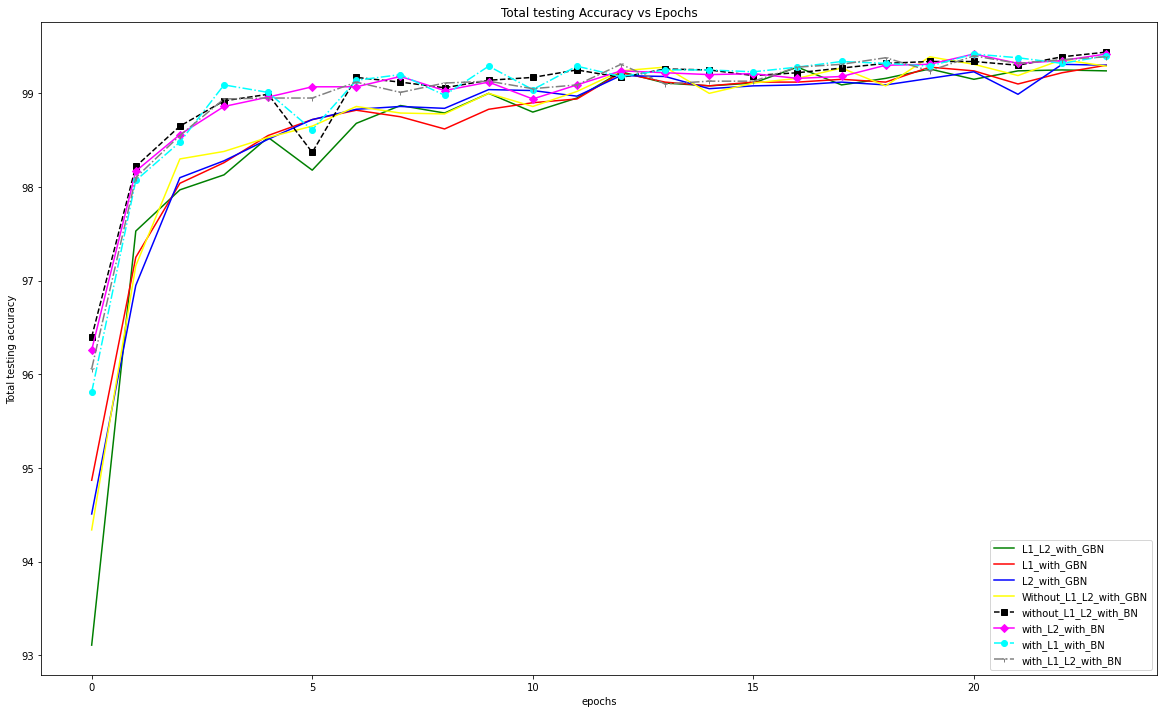

In [0]:
plt.figure(figsize=(20,12))
plt.plot(total_acc[0],color='Green',label='L1_L2_with_GBN')
plt.plot(total_acc[1],color='Red',label='L1_with_GBN')
plt.plot(total_acc[2],color='Blue',label='L2_with_GBN')
plt.plot(total_acc[3],color='Yellow',label='Without_L1_L2_with_GBN')
plt.plot(total_acc[4],c='Black',marker = 's' , ls = '--' , label = 'without_L1_L2_with_BN' )
plt.plot(total_acc[6],c='Magenta', marker = 'D' , ls = '-' , label = 'with_L2_with_BN' )
plt.plot(total_acc[5],c='Cyan' , marker = 'o' , ls = '-.' , label = 'with_L1_with_BN')
plt.plot(total_acc[7],c='Grey' , marker = '1' , ls = '-.' , label = 'with_L1_L2_with_BN')
plt.xlabel('Total Epoch ')
plt.ylabel(' Accuracy ')
plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))

plt.title('Total testing Accuracy vs Epochs')
plt.legend()
plt.ylabel('Total testing accuracy')
plt.xlabel('epochs')
plt.show()